In [3]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

## Data Preprocessing

In [4]:
# read dataset

dt = pd.read_csv('data_train.csv')
dt = dt.sample(frac=1)

dt

,tweet,label
512,20 kan gak nyampe cuma lucu lucuan doang sih ...,hujatan
606,mbok ya tunda dlu obral stan politik negeri se...,hujatan
396,93 saya hargai nasdem tapi bukan mendukung da...,netral
1204,NaN,NaN
1692,nasdem setuju dia orang pintar dan baik,dukungan
...,...,...
424,,NaN
1210,NaN,NaN
1489,NaN,NaN
390,metro tv jadi sahabat kadrun sekarang gak dib...,hujatan


In [5]:
# delete NaN data
dt.dropna(inplace=True)

dt

,tweet,label
512,20 kan gak nyampe cuma lucu lucuan doang sih ...,hujatan
606,mbok ya tunda dlu obral stan politik negeri se...,hujatan
396,93 saya hargai nasdem tapi bukan mendukung da...,netral
1692,nasdem setuju dia orang pintar dan baik,dukungan
178,anies ridwan boleh lah pokok wis gak pdip2 clu...,dukungan
...,...,...
1417,nasdem orang jg gak sembrono nolak anies,dukungan
1623,harrisbarus ya allah aku berlindung kepadamu d...,dukungan
657,resmi usung anies baswedan sebagai capres sur...,dukungan
390,metro tv jadi sahabat kadrun sekarang gak dib...,hujatan


In [6]:
# update label

dt['label'] = dt['label'].replace({'pujian':'dukungan', 'hujatan':'tidak mendukung'})

dt['label'].value_counts()

dukungan           569
tidak mendukung    486
netral             181
Name: label, dtype: int64

## Data Preparation

dukungan           569
tidak mendukung    486
netral             181
Name: label, dtype: int64

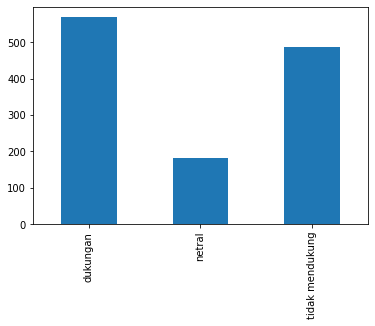

In [7]:
# visualize data

dt['label'].value_counts().sort_index().plot.bar()
dt['label'].value_counts()

# Minority oversampling

In [8]:
minority_class = 'netral'
num_samples_to_oversample = dt['label'].value_counts()['dukungan'] - dt['label'].value_counts()[minority_class]

In [9]:
minority_df = dt[dt['label'] == minority_class]

In [10]:
oversampled_df = minority_df.sample(num_samples_to_oversample, replace=True)


In [11]:
dt = pd.concat([dt, oversampled_df])

In [12]:
minority_class = 'tidak mendukung'
num_samples_to_oversample = dt['label'].value_counts()['dukungan'] - dt['label'].value_counts()[minority_class]

In [13]:
minority_df = dt[dt['label'] == minority_class]

In [14]:
oversampled_df = minority_df.sample(num_samples_to_oversample, replace=True)

In [15]:
dt = pd.concat([dt, oversampled_df])

tidak mendukung    569
netral             569
dukungan           569
Name: label, dtype: int64

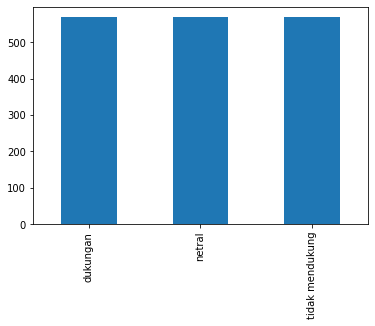

In [16]:
dt['label'].value_counts().sort_index().plot.bar()
dt['label'].value_counts()

In [17]:
# tokenizer text

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(dt['tweet'].values)
X = tokenizer.texts_to_sequences(dt['tweet'].values)
X = pad_sequences(X)
print(X)

[[   0    0    0 ...  414  124    8]
 [   0    0    0 ... 1627 2405 1628]
 [   0    0    0 ...    9   75   80]
 ...
 [   0    0    0 ...    4 2108 1166]
 [   0    0    0 ...   19 2238 2239]
 [   0    0    0 ...   90   39 1988]]


In [18]:
# get label

y = pd.get_dummies(dt['label']).values
y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [19]:
print(y.shape)

(1707, 3)


In [20]:
# split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(1365, 51)
(342, 51)


## Training Model

In [21]:
# LSTM Modelling

model = Sequential()
model.add(Embedding(5000, 256))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2023-03-01 10:04:00.683220: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 10:04:00.683474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-01 10:04:00.683697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-01 10:04:00.683858: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-01 10:04:00.684013: W tensorfl

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm (LSTM)                 (None, None, 256)         525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [22]:
# train model

batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test))

# save model into file .h5

model.save('sentiment_analysis.h5')

Epoch 1/10
43/43 - 52s - loss: 1.0653 - accuracy: 0.4300 - val_loss: 1.0137 - val_accuracy: 0.5175 - 52s/epoch - 1s/step
Epoch 2/10
43/43 - 33s - loss: 0.6301 - accuracy: 0.7597 - val_loss: 0.6305 - val_accuracy: 0.7632 - 33s/epoch - 760ms/step
Epoch 3/10
43/43 - 33s - loss: 0.2260 - accuracy: 0.9187 - val_loss: 0.5650 - val_accuracy: 0.8041 - 33s/epoch - 762ms/step
Epoch 4/10
43/43 - 32s - loss: 0.0932 - accuracy: 0.9729 - val_loss: 0.9539 - val_accuracy: 0.8041 - 32s/epoch - 752ms/step
Epoch 5/10
43/43 - 32s - loss: 0.0758 - accuracy: 0.9766 - val_loss: 0.6155 - val_accuracy: 0.7982 - 32s/epoch - 751ms/step
Epoch 6/10
43/43 - 34s - loss: 0.0347 - accuracy: 0.9912 - val_loss: 0.6131 - val_accuracy: 0.8012 - 34s/epoch - 784ms/step
Epoch 7/10
43/43 - 35s - loss: 0.0367 - accuracy: 0.9934 - val_loss: 0.6358 - val_accuracy: 0.8158 - 35s/epoch - 824ms/step
Epoch 8/10
43/43 - 33s - loss: 0.0220 - accuracy: 0.9956 - val_loss: 0.5540 - val_accuracy: 0.8216 - 33s/epoch - 776ms/step
Epoch 9/10


In [23]:
import seaborn as sns
import string

In [24]:
# Mengambil data dari history pelatihan model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [25]:
# Membuat plot
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

<Figure size 864x360 with 0 Axes>

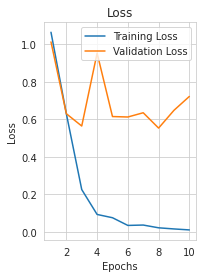

In [26]:
plt.subplot(1,2,1)
sns.lineplot(x=range(1,epochs+1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1,epochs+1), y=val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

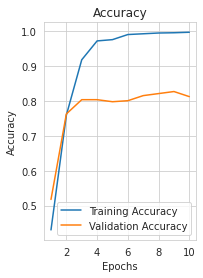

In [27]:
plt.subplot(1,2,2)
sns.lineplot(x=range(1,epochs+1), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1,epochs+1), y=val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

11/11 [==============================] - 3s 158ms/step
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       109
           1       0.88      0.95      0.92       110
           2       0.85      0.70      0.77       123

    accuracy                           0.81       342
   macro avg       0.82      0.82      0.81       342
weighted avg       0.82      0.81      0.81       342



In [29]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

[[ 87   7  15]
 [  5 105   0]
 [ 30   7  86]]


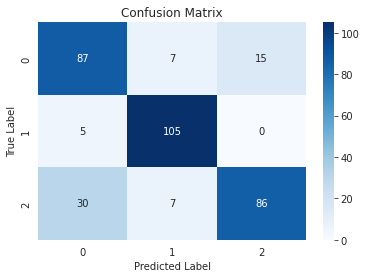

In [30]:
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [31]:
# evaluate model with data test

score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

11/11 - 2s - loss: 0.7228 - accuracy: 0.8129 - 2s/epoch - 147ms/step
score: 0.72
acc: 0.81


## Evaluate Model

In [47]:
# evaluate model with data test

score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

11/11 - 1s - loss: 0.7208 - accuracy: 0.8304 - 1s/epoch - 110ms/step
score: 0.72
acc: 0.83


## Predict New Dataset

In [48]:
# read new dataset
import re
import numpy as np
import pandas as pd
data = pd.read_csv('tweet2.csv')
# menghapus kolom id
data = data.drop(['id'], axis=1)

data

,tweet
0,"@M45Broo_ Cebong benar2 panik luar biasa, ini ..."
1,@Relawananies https://t.co/uf5sE0iGLI
2,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
3,RT @aLy_Bima: Video ini hanya untuk orang yang...
4,"RT @tempodotco: ""Tidak ringan permasalahan di ..."
...,...
445,RT @Relawananies: Momen haru saat Anies Baswed...
446,@maspiyuaja Terima kasih om https://t.co/PUgr2...
447,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
448,RT @OposisiCerdas: Kamhar Lakumani Sebut Anies...


In [49]:
# data preprocessing

def tweetPrepocessing(text):
  text = text.lower()
  text = re.sub('\n','', text)
  text = re.sub('rt ','', text)
  text = re.sub('#','', text)
  text = re.sub('@\w+(?:\:)\ ','', text)
  text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+','', text)
  text = re.sub('[^a-zA-z0-9\s]','', text)
  text = re.sub('  ',' ', text)

  if text == ' ':
    return None

  return text

data = data.sample(frac=1)
data['tweet'] = data['tweet'].apply(tweetPrepocessing)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace = True)

data

,tweet
0,kenduri rakyat jarnas anies baswedan yogyakart...
1,brengsek anies baswedan gak bisa kerja sekaran...
2,hanya pandai omdo ajakelebihan bayar dn php
3,ketum partai gerindra prabowo subianto memilik...
4,indonesiamemanggil 5 tahun anies baswedan memi...
...,...
430,sinyal buat koalisi ak2412 oktoober 2022jender...
431,janji anies baswedan menjadi jancukkepulauan b...
432,kenapa disaat last lap pencitraan
433,partai koalisi pemerintah 82 suaranya di parle...


In [50]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X)
print(X)


tokenizer.fit_on_texts(data['tweet'].values)

X_new = tokenizer.texts_to_sequences(data['tweet'].values)
X_new = pad_sequences(X_new)
X_new.shape

[[   0    0    0 ...    1   62  425]
 [   0    0    0 ...   67   76  428]
 [   0    0    0 ...  635  218  636]
 ...
 [   0    0    0 ... 1546 1547 1548]
 [   0    0    0 ...   56   18   59]
 [   0    0    0 ...  453   38 1549]]


(435, 42)

In [51]:
# load model
from keras.models import Sequential, load_model
mymodel = load_model('sentiment_analysis.h5')

In [52]:
# predict data

pred = mymodel.predict(X_new)

14/14 [==============================] - 1s 49ms/step


In [53]:
# labelling

def labelling(array):
  labels = ['dukungan', 'netral', 'tidak mendukung']
  output = []
  for a in array:
    output.append(labels[np.argmax(a)])
  return output

label = labelling(pred)

In [54]:
# add label to data

data['label'] = label

data

,tweet,label
0,kenduri rakyat jarnas anies baswedan yogyakart...,netral
1,brengsek anies baswedan gak bisa kerja sekaran...,netral
2,hanya pandai omdo ajakelebihan bayar dn php,netral
3,ketum partai gerindra prabowo subianto memilik...,tidak mendukung
4,indonesiamemanggil 5 tahun anies baswedan memi...,tidak mendukung
...,...,...
430,sinyal buat koalisi ak2412 oktoober 2022jender...,netral
431,janji anies baswedan menjadi jancukkepulauan b...,dukungan
432,kenapa disaat last lap pencitraan,tidak mendukung
433,partai koalisi pemerintah 82 suaranya di parle...,dukungan


In [43]:
# save to new csv

data.to_csv('tweet2_new.csv', index=False)